In [15]:
!pip uninstall numpy
!pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 69.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
xarray-einstats 0.9.0 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
bigframes 2.5.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.8 requires numpy>

In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

In [3]:
from colabgymrender.recorder import Recorder

  from scipy.ndimage.filters import sobel



In [4]:
# install dependencies
!apt install chromium-browser xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
chromium-browser is already the newest version (1:85.0.4183.83-0ubuntu2.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.14).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


# CartPole

In [23]:
env = gym.make('CartPole-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0

while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env.play()


  logger.warn(

  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



18.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [7]:
total_reward

12.0

In [34]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 50000
epsilon_decay_intervals = 10000
gamma = 0.99 # discount
alpha = 5e-4 # learning rate

memory_size = 50000
min_replay_size = 1000
batch_size = 32

target_update_frequency = 1000 # target network update frequency

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 64),
            nn.Tanh(),
            nn.Linear(64, env.action_space.n))

    def forward(self, state):
        return self.network(state)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

In [8]:
def fill_memory(env):
    memory = deque(maxlen=memory_size)
    state = env.reset()
    for _ in range(min_replay_size):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            env.reset()

    return memory

In [9]:
def dqn_training(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr):
    q_net = NeuralNetwork(env)
    target_net = NeuralNetwork(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory(env)
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)

        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0


        # Take a batch of experiences from the memory
        experiences = random.sample(memory, batch_size)
        states = [ex[0] for ex in experiences]
        actions = [ex[1] for ex in experiences]
        rewards = [ex[2] for ex in experiences]
        dones = [ex[3] for ex in experiences]
        next_states = [ex[4] for ex in experiences]

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        # Compute targets using the formulation sample = r + gamma * max q(s',a')
        target_q_values = target_net(next_states)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rewards + gamma * (1-dones) * max_target_q_values

        # Compute loss
        q_values = q_net(states)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions)
        loss = torch.nn.functional.mse_loss(action_q_values, targets)

        # gradient descent for q-network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update target network
        if (step+1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        # print training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')

    return all_rewards, q_net

In [21]:
all_rewards, q_net = dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Episode: 43 Step: 1000 Average reward: 23.209302325581394
Episode: 86 Step: 2000 Average reward: 23.0
Episode: 117 Step: 3000 Average reward: 25.87
Episode: 153 Step: 4000 Average reward: 27.77
Episode: 188 Step: 5000 Average reward: 29.61
Episode: 214 Step: 6000 Average reward: 30.23
Episode: 247 Step: 7000 Average reward: 31.75
Episode: 270 Step: 8000 Average reward: 34.34
Episode: 291 Step: 9000 Average reward: 39.36
Episode: 316 Step: 10000 Average reward: 39.09
Episode: 337 Step: 11000 Average reward: 42.07
Episode: 357 Step: 12000 Average reward: 46.2
Episode: 375 Step: 13000 Average reward: 47.59
Episode: 394 Step: 14000 Average reward: 48.57
Episode: 408 Step: 15000 Average reward: 53.27
Episode: 422 Step: 16000 Average reward: 56.36
Episode: 435 Step: 17000 Average reward: 60.6
Episode: 447 Step: 18000 Average reward: 65.93
Episode: 462 Step: 19000 Average reward: 66.48
Episode: 475 Step: 20000 Average reward: 68.76
Episode: 488 Step: 21000 Average reward: 72.22
Episode: 506 S

KeyboardInterrupt: 

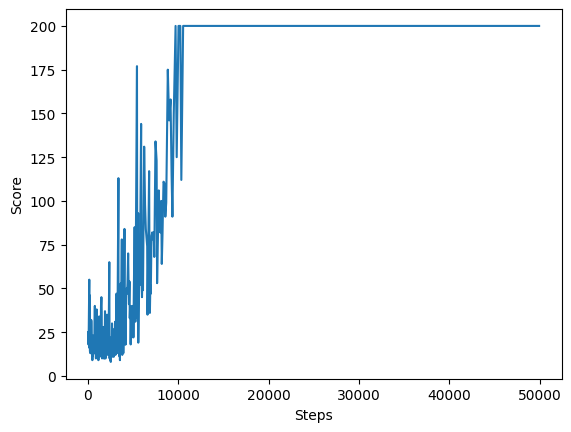

In [14]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [ ]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [15]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



200.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


# Mountain Car

In [5]:
env = gym.make('MountainCar-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0

while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env.play()


  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-200.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [58]:
total_reward

-200.0

In [12]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 500000
epsilon_decay_intervals = 300000
gamma = 0.99 # discount
alpha = 5e-4 # learning rate

memory_size = 100000
min_replay_size = 10000
batch_size = 64

target_update_frequency = 2000 # target network update frequency

In [60]:
all_rewards, q_net = dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)

Episode: 5 Step: 1000 Average reward: -200.0
Episode: 10 Step: 2000 Average reward: -200.0
Episode: 15 Step: 3000 Average reward: -200.0
Episode: 20 Step: 4000 Average reward: -200.0
Episode: 25 Step: 5000 Average reward: -200.0
Episode: 30 Step: 6000 Average reward: -200.0
Episode: 35 Step: 7000 Average reward: -200.0
Episode: 40 Step: 8000 Average reward: -200.0
Episode: 45 Step: 9000 Average reward: -200.0
Episode: 50 Step: 10000 Average reward: -200.0
Episode: 55 Step: 11000 Average reward: -200.0
Episode: 60 Step: 12000 Average reward: -200.0
Episode: 65 Step: 13000 Average reward: -200.0
Episode: 70 Step: 14000 Average reward: -200.0
Episode: 75 Step: 15000 Average reward: -200.0
Episode: 80 Step: 16000 Average reward: -200.0
Episode: 85 Step: 17000 Average reward: -200.0
Episode: 90 Step: 18000 Average reward: -200.0
Episode: 95 Step: 19000 Average reward: -200.0
Episode: 100 Step: 20000 Average reward: -200.0
Episode: 105 Step: 21000 Average reward: -200.0
Episode: 110 Step: 22

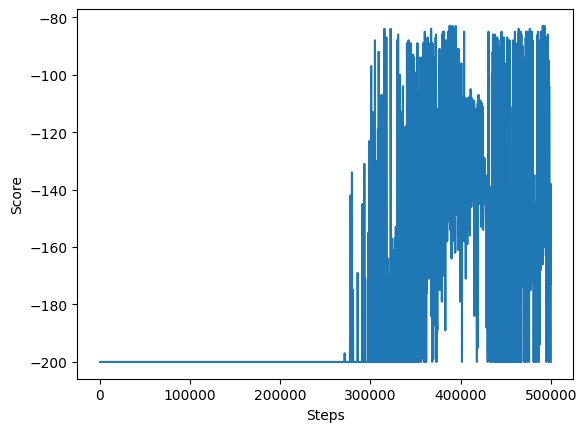

In [61]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [62]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-95.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [13]:
import random
from collections import deque

import numpy as np
import torch
import torch.nn.functional as F

def double_dqn_training(env,
                        max_num_steps,
                        max_epsilon, min_epsilon,
                        num_epsilon_decay_intervals,
                        gamma, lr,
                        batch_size=64,
                        target_update_frequency=1000,
                        log_interval=1000):
    # 1) Khởi tạo online & target networks
    q_net      = NeuralNetwork(env)
    target_net = NeuralNetwork(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer  = torch.optim.Adam(q_net.parameters(), lr=lr)

    # 2) Seed replay buffer
    memory = fill_memory(env)

    # 3) Đệm lưu return của 100 episodes gần nhất
    reward_buffer = deque(maxlen=100)
    reward_per_episode = 0.0

    state = env.reset()
    all_rewards = []

    for step in range(max_num_steps):
        # --- ε-greedy policy ---
        epsilon = np.interp(step,
                            [0, num_epsilon_decay_intervals],
                            [max_epsilon, min_epsilon])
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)

        # 4) Tương tác với môi trường
        next_state, reward, done, _ = env.step(action)
        memory.append((state, action, reward, done, next_state))
        reward_per_episode += reward
        state = next_state

        # 5) Khi kết thúc 1 episode, lưu tổng return và reset
        if done:
            reward_buffer.append(reward_per_episode)
            all_rewards.append(reward_per_episode)
            reward_per_episode = 0.0
            state = env.reset()

        # 6) Chỉ train khi đã có đủ batch
        if len(memory) >= batch_size:
            batch = random.sample(memory, batch_size)
            states, actions, rewards, dones, next_states = zip(*batch)

            states      = torch.tensor(states, dtype=torch.float32)
            actions     = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
            rewards     = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
            dones       = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)
            next_states = torch.tensor(next_states, dtype=torch.float32)

            # --- Double DQN target computation ---
            with torch.no_grad():
                # (1) online_net chọn action tốt nhất
                next_q_online     = q_net(next_states)
                best_next_actions = next_q_online.argmax(dim=1, keepdim=True)
                # (2) target_net đánh giá giá trị của action đó
                next_q_target = target_net(next_states)
                q_next_best   = next_q_target.gather(1, best_next_actions)
                # (3) target
                targets = rewards + gamma * (1 - dones) * q_next_best

            # --- Q(s,a) hiện tại & loss ---
            q_values        = q_net(states)
            action_q_values = q_values.gather(1, actions)
            loss = F.mse_loss(action_q_values, targets)

            # --- gradient descent + gradient clipping ---
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(q_net.parameters(), max_norm=1.0)
            optimizer.step()

        # 7) Cập nhật target network mỗi target_update_frequency step
        if (step + 1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        # 8) In log tương tự screenshot của bạn
        if (step + 1) % log_interval == 0:
            avg_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {avg_reward}')

    return all_rewards, q_net


In [14]:
all_rewards, q_net = double_dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  states      = torch.tensor(states, dtype=torch.float32)



Episode: 5 Step: 1000 Average reward: -200.0
Episode: 10 Step: 2000 Average reward: -200.0
Episode: 15 Step: 3000 Average reward: -200.0
Episode: 20 Step: 4000 Average reward: -200.0
Episode: 25 Step: 5000 Average reward: -200.0
Episode: 30 Step: 6000 Average reward: -200.0
Episode: 35 Step: 7000 Average reward: -200.0
Episode: 40 Step: 8000 Average reward: -200.0
Episode: 45 Step: 9000 Average reward: -200.0
Episode: 50 Step: 10000 Average reward: -200.0
Episode: 55 Step: 11000 Average reward: -200.0
Episode: 60 Step: 12000 Average reward: -200.0
Episode: 65 Step: 13000 Average reward: -200.0
Episode: 70 Step: 14000 Average reward: -200.0
Episode: 75 Step: 15000 Average reward: -200.0
Episode: 80 Step: 16000 Average reward: -200.0
Episode: 85 Step: 17000 Average reward: -200.0
Episode: 90 Step: 18000 Average reward: -200.0
Episode: 95 Step: 19000 Average reward: -200.0
Episode: 100 Step: 20000 Average reward: -200.0
Episode: 105 Step: 21000 Average reward: -200.0
Episode: 110 Step: 22

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

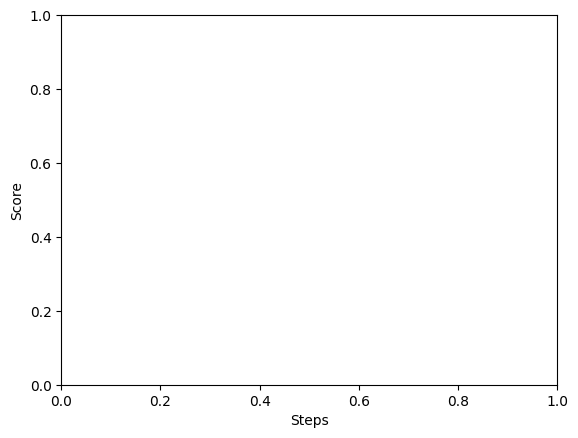

In [15]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [16]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-86.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


# Nhận xét

Những thay đổi về tham số:
*   max_num_steps = 50000 -> max_num_steps = 500000
*   batch_size = 32 -> batch_size = 64
*   epsilon_decay_intervals = 10000 -> epsilon_decay_intervals = 300000
*   memory_size = 50000 -> memory_size = 100000
*   min_replay_size = 1000 -> min_replay_size = 10000






Tạo thêm một bản cải tiến của DQN đó là double DQN để cải thiện reward với tham số mới. Số điểm nhận được tăng từ -95 lên -86

DQN gốc: dùng cùng một mạng để chọn và đánh giá → noise ở cả hai bước cộng gộp vào nhau → over-estimation.

Double DQN:

Bước 1: chọn hành động bằng mạng “online” (cập nhật liên tục)

Bước 2: đánh giá hành động đó bằng mạng “target” (ít cập nhật hơn)
→ giảm việc noise “tự củng cố” → Q-values ít bị thổi phồng